##### Import packages

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys 
import os
sys.path.insert(0, os.getcwd())

In [5]:
import torch 
import pickle
import nibabel

from jrieke.utils import load_nifti, save_nifti
from innvestigator import InnvestigateModel
from settings import settings
from utils import load_data, scale_mask
from jrieke import interpretation
from nmm_mask_areas import all_areas

import numpy as np
import pickle
import jrieke.models as models


for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding data_path to namespace
Adding nmm_mask_path to namespace


## Load model

In [6]:
device = 0
net = models.ClassificationModel3D()
net.cuda(device)
net.eval()
net.load_state_dict(torch.load(model_path,
                              map_location='cpu'))
net = torch.nn.Sequential(net, torch.nn.Softmax(dim=1))
inn_model = InnvestigateModel(net, lrp_exponent=1,
                                  method="b-rule",
                                  beta=.5, epsilon=1e-6).cuda(device)
inn_model.eval();


## Load ADNI Data

In [7]:
train_dataset, test_dataset = load_data()

Loading dataframe for /analysis/ritter/data/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_1_5T.csv
Found 1590 images in table
Filtered out 2 of 1590 images because of failed preprocessing
Filtered out 0 of 1588 images because of missing files
Filtered out 619 of 1588 images that were MCI
Final dataframe contains 969 images from 344 patients

         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         969      475      494         344      193      151
Train       794      399      395         284      163      121
Val         175       76       99          60       30       30

Calculating mean and std for normalization:


## Load mask

In [11]:
if False:
    mri_shape = train_dataset.image_shape()
    neuromorph_map = nibabel.load(nmm_mask_path).get_data()
    nmm_mask = scale_mask(neuromorph_map, mri_shape)
    save_nifti(data_path + "rescaled_nmm_mask.nii", nmm_mask)
else:
    nmm_mask = load_nifti(data_path + "rescaled_nmm_mask.nii")

# all_areas holds the area name and a tuple with the minimum 
# idx in the NMM mask and the maximum idx in the NMM mask belonging to that area
area_masks = {k: None for k in all_areas.keys()}
for name, (min_idx, max_idx) in all_areas.items():
    area_mask = np.zeros(mri_shape)
    area_mask[np.logical_and(nmm_mask>=min_idx, nmm_mask<=max_idx)] = 1
    area_masks[name] = area_mask

## Evaluate Guided Backprop and LRP on dataset

In [12]:
def run_guided_backprop(net, image_tensor):
    return interpretation.guided_backprop(net, image_tensor, cuda=True, verbose=False, apply_softmax=False)

def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=1)

In [13]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]
mean_maps_GB = {case: np.zeros(mri_shape) for case in cases}
mean_maps_LRP = {case: np.zeros(mri_shape) for case in cases}
rs_per_area_LRP = {case: {k: [] for k in all_areas.keys()} for case in cases}
rs_per_area_GB = {case: {k: [] for k in all_areas.keys()} for case in cases}
counts = {case: 0 for case in cases}
area_sizes = {k: 0 for k in all_areas.keys()}

#####  Run evaluation

In [14]:
num_samples = len(test_dataset)

ad_score_list = []


for i in range(num_samples):
    
    image_tensor, label = test_dataset[i]
    image_tensor = image_tensor[None].cuda(device)
    GB_map = run_guided_backprop(inn_model, image_tensor).squeeze()
    AD_score, LRP_map = run_LRP(inn_model, image_tensor)
    AD_score = AD_score[0][1].detach().cpu().numpy()
    LRP_map = LRP_map.detach().numpy().squeeze()
    ad_score_list.append(AD_score)
    
    true_case = "AD" if label else "HC"
    if AD_score.round() and label:
        case = "TP"
    elif AD_score.round() and not label:
        case = "FP"
    elif not AD_score.round() and label:
        case = "FN"
    elif not AD_score.round() and not label:
        case = "TN"
    
    mean_maps_GB[case] += GB_map
    mean_maps_LRP[case] += LRP_map
    counts[case] += 1
    mean_maps_GB[true_case] += GB_map
    mean_maps_LRP[true_case] += LRP_map
    counts[true_case] += 1
    
    for name, (min_idx, max_idx) in all_areas.items():
        area_mask = area_masks[name]
        summed_LRP = (LRP_map * area_mask).sum()
        summed_GB = (GB_map * area_mask).sum()
        
        # Keep index in test set for identification
        rs_per_area_LRP[case][name].append((i, summed_LRP))
        rs_per_area_LRP[true_case][name].append((i, summed_LRP))
        rs_per_area_GB[case][name].append((i, summed_GB))
        rs_per_area_GB[true_case][name].append((i, summed_GB))
        if i < 1:
            area_size = area_mask.sum()
            area_sizes.update({name:area_size})
    
    print("Completed {0:3.2f}%  \r".format(100*(i+1)/num_samples), end="")
        
for case in cases:
    save_nifti(data_path + "LRP_{case}.nii".format(case=case),
               mean_maps_LRP[case]/counts[case])
    save_nifti(data_path + "GB_{case}.nii".format(case=case),
               mean_maps_GB[case]/counts[case])
    with open(data_path + "LRP_area_evdcs_{case}.pkl".format(case=case), 'wb') as file:
        pickle.dump(rs_per_area_LRP[case], file)
    with open(data_path + "GB_area_evdcs_{case}.pkl".format(case=case), 'wb') as file:
        pickle.dump(rs_per_area_GB[case], file)

with open(data_path + "area_sizes.pkl", 'wb') as file:
    pickle.dump(area_sizes, file)

np.savetxt(data_path + "ad_scores.txt", ad_score_list)

## Plotting individual heatmaps

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
%matplotlib inline

In [16]:
def get_heatmaps(idx):
    image_tensor, label = test_dataset[idx]
    image_tensor = image_tensor[None]
    image_tensor_LRP = image_tensor.cuda(device)
    print("Running GB")
    rel_GB = run_guided_backprop(inn_model, image_tensor_LRP)
    print("Running LRP")
    AD_score, rel_LRP = run_LRP(inn_model, image_tensor_LRP)
    print(label, AD_score)
    return rel_LRP.detach().numpy().squeeze(), rel_GB.squeeze()

In [17]:
patient_idx = np.random.randint(0, len(test_dataset)-1)
LRP_map, GB_map = get_heatmaps(patient_idx)

Running GB
Running LRP
tensor(1) tensor([[0.1325, 0.8675]], device='cuda:0')


In [46]:

def plot_idv_brain(heat_map, brain_img, ref_scale, fig=None, ax=None, 
                  x_idx=slice(0, mri_shape[0]), y_idx=slice(0, mri_shape[1]), z_idx=slice(0, mri_shape[2]),
                  vmin=90, vmax=99.5, set_nan=True, cmap=None):

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[nmm_mask==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    if brain_img is not None:
        ax.imshow(brain_img[x_idx, y_idx, z_idx].T, cmap="Greys")

    vmin_val, vmax_val = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin_val, vmax=vmax_val, interpolation="gaussian")
       
    ax.axis('off')
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, shrink=0.5, ticks=[vmin, vmax], cax=cbar_ax)
    cbar.set_ticks([vmin_val, vmax_val])
    cbar.ax.set_yticklabels(['{0:.1f}%'.format(vmin), '{0:.1f}%'.format(vmax)], fontsize=14)
    cbar.set_label('Percentile of  average AD patient values\n', rotation=270, fontsize=14)

    return fig, ax


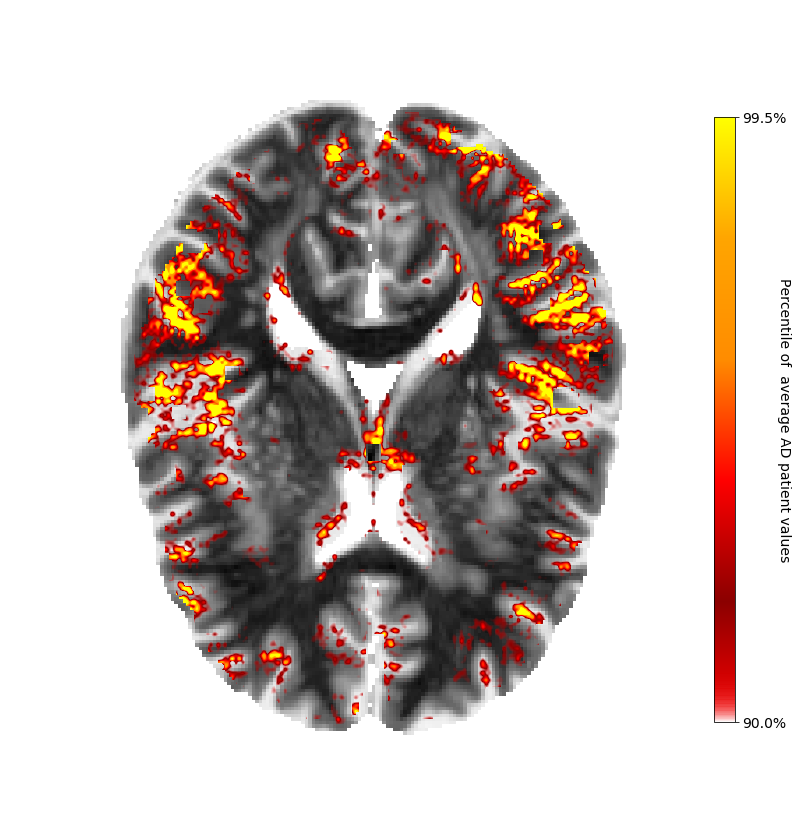

In [47]:
fig, ax = plot_idv_brain(LRP_map, test_dataset.get_raw_image(patient_idx),
                            ref_scale=mean_maps_LRP["AD"],
                            z_idx=90)

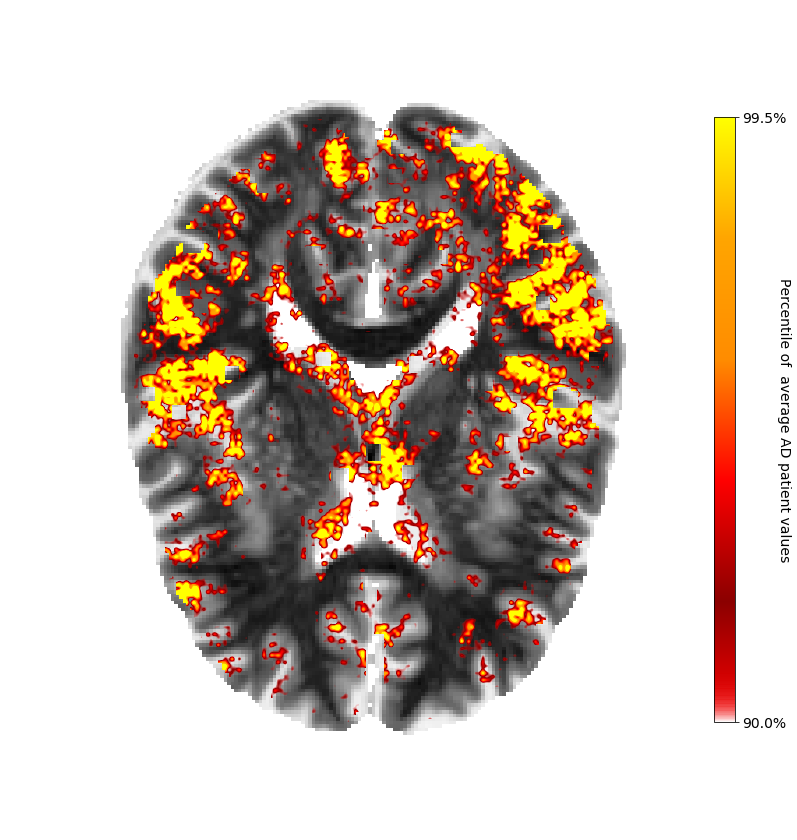

In [49]:
fig, ax = plot_idv_brain(GB_map, test_dataset.get_raw_image(patient_idx),
                            ref_scale=mean_maps_GB["AD"],
                            z_idx=90)